# Ch05 


In [35]:
import pandas as pd
import numpy as np 

import matplotlib as mpl 
import matplotlib.pyplot as plt 

import statsmodels.api as sm


In [36]:
%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


## 5.1 Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

In [33]:
np.random.seed(0)

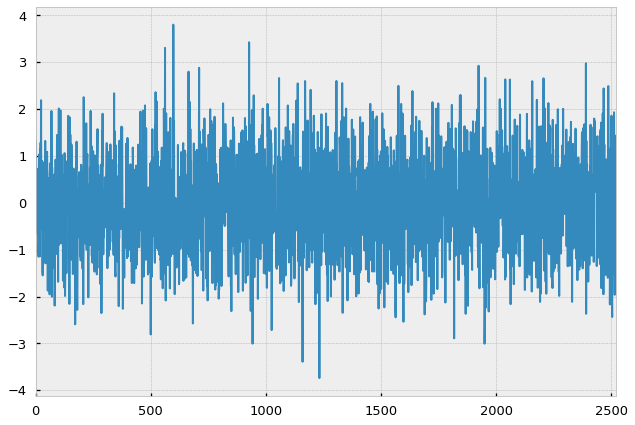

In [37]:
N = 252 * 10
s = pd.Series(np.random.randn(N))
s.plot()


## (a) Compute the ADF statistic on this series. What is the p-value? 

In [6]:
adf = lambda s: sm.tsa.stattools.adfuller(s)
p_val = lambda s: sm.tsa.stattools.adfuller(s)[1]
res = adf(s)
p = res[1]

res, p


((-50.80332180276013,
  0.0,
  0,
  2519,
  {'1%': -3.4329486408391174,
   '5%': -2.8626880695259413,
   '10%': -2.567381161224712},
  6950.968131407137),
 0.0)

## (b) Compute the cumulative sum of the observations. This is a non-stationary series w/o memory. 

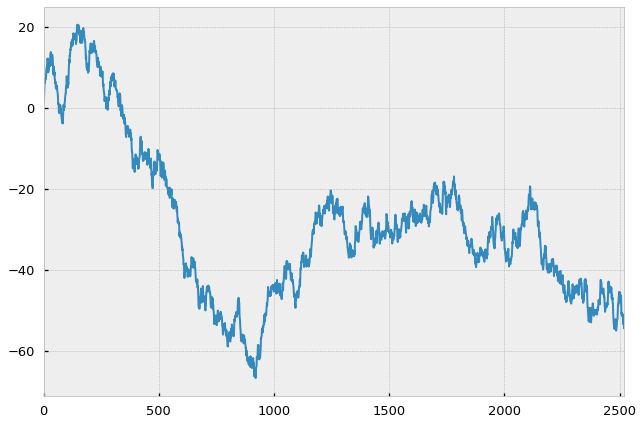

In [7]:
cmsm = pd.Series(s).cumsum()
cmsm.plot()

In [8]:
p_val(cmsm)

0.5704444806659968

# [5.2] Generate a time series that follows a sinusoidal function. This is a stationary series with memory. 

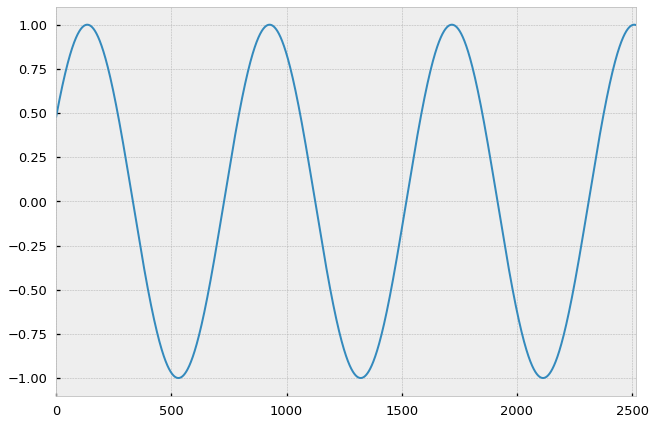

In [9]:
np.random.seed(0)

rand = np.random.random(N)

idx = np.linspace(0, 10, N)
s = pd.Series(1 * np.sin(2. * idx + .5))
s.plot()


In [10]:
p_val(s)

0.0

## (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

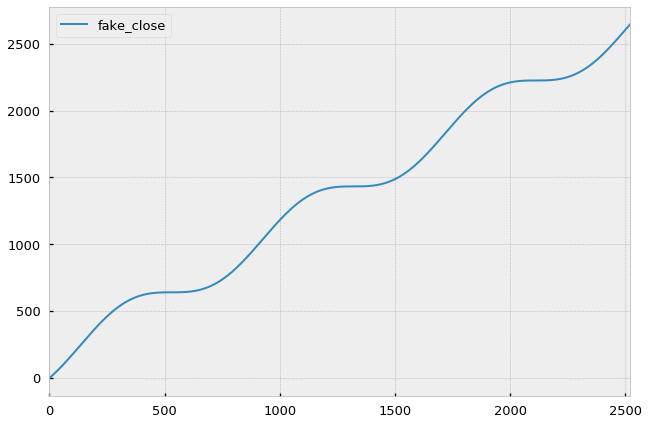

In [12]:
s_ = (s + 1).cumsum().rename('fake_close').to_frame()
s_.plot()

In [13]:
adf(s_['fake_close'].dropna()), p_val(s_['fake_close'])

((-0.12759509265544455,
  0.9466196428810949,
  27,
  2492,
  {'1%': -3.432976825339513,
   '5%': -2.862700515844509,
   '10%': -2.5673877878037974},
  -142670.31444901065),
 0.9466196428810949)

In [14]:
def getWeights(d, size): 
    # thres > 0 drops insignificant weights 
    w = [1.]
    for k in range(1, size): 
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        
    w = np.array(w[::-1]).reshape(-1, 1)
    return w 

In [41]:
s_.shape[0]

2520

In [20]:
%%time
w = getWeights(0.1, s_.shape[0])


CPU times: user 432 µs, sys: 143 µs, total: 575 µs
Wall time: 577 µs


In [23]:
def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [24]:
df0 = fracDiff(s_, 0.1)

In [27]:
df0.head()

,fake_close
1757,950.133846
1758,951.122082
1759,952.108028
1760,953.091649
1761,954.072911


,adfStat,pVal,lags,nObs,95% conf
0.0,2.833609e+00,1.000000e+00,1.0,2517.0,-2.862689
0.1,8.870880e+00,1.000000e+00,1.0,761.0,-2.865345
0.2,-7.366367e+00,9.213847e-11,1.0,963.0,-2.864546
0.3,-2.267608e+01,0.000000e+00,1.0,1357.0,-2.863672
0.4,-2.259792e+01,0.000000e+00,1.0,1821.0,-2.863128
0.5,-3.781556e+01,0.000000e+00,1.0,2188.0,-2.862862
0.6,-4.388734e+01,0.000000e+00,1.0,2385.0,-2.862753
0.7,-6.322546e+01,0.000000e+00,1.0,2466.0,-2.862713
0.8,-7.371512e+01,0.000000e+00,1.0,2497.0,-2.862698
0.9,-4.877829e+01,0.000000e+00,1.0,2510.0,-2.862692


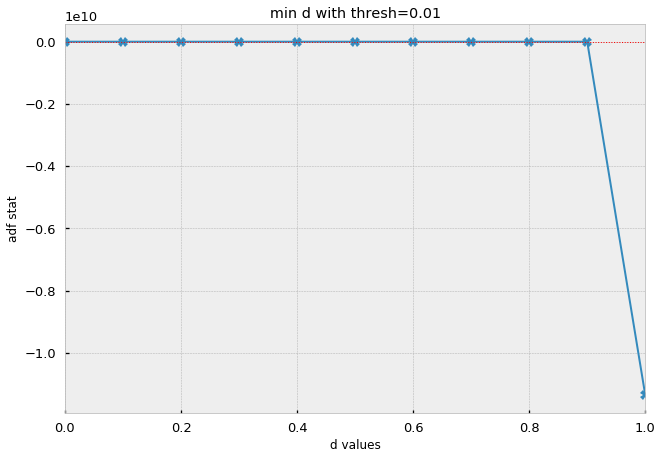

In [33]:
cols = ['adfStat','pVal','lags','nObs','95% conf'] #,'corr']

out = pd.DataFrame(columns = cols)

for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(s_, d)
        df0 = sm.tsa.stattools.adfuller(df0['fake_close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df0[:4])+[df0[4]['5%']]
    except: 
        break


f, ax = plt.subplots()

out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(), lw=1, color='r', ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');


display(out)

# APPENDIX